This tutorial deals with __reading a SEG2 file__. 

Let's start by importing some packages (including the seisio package itself) and setting up the logging config.

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(1, '../')

In [2]:
import seisio

In [3]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s', force=True)
log = logging.getLogger("main")

Let's create the seisio object. Under ideal circumstances, the module can determine all relevant parameters automatically to read the file correctly:

In [4]:
file = "data/shot1.seg2"

sio = seisio.input(file)

INFO: Input file: data/shot1.seg2
INFO: Valid SEG2 file descriptor found. File endianess: '<'.
INFO: File standard is SEG2 rev. 1.
INFO: Number of data traces in file: 48.
INFO: Valid SEG2 trace descriptor found on first trace.
INFO: Number of samples on first data trace: 1000.
INFO: Data sample format: 4-byte IEEE floating-point.


In [5]:
nt = sio.ntraces
ns = sio.nsamples
dt = sio.vsi
log.info("nt=%d, ns=%d, dt on first trace=%e", nt, ns, dt)

INFO: nt=48, ns=1000, dt on first trace=2.500000e-04


Let's get the strings from the SEG2 file header block:

In [6]:
fheader = sio.fheader
for key in fheader:
    if key == "NOTE":
        for i, k in enumerate(fheader[key]):
            log.info("File header 'NOTE' entry #%d: %s", i, k)
    else:
        log.info("File header: string='%s', value='%s'", key, fheader[key])

INFO: File header: string='ACQUISITION_DATE', value='04/May/2023'
INFO: File header: string='ACQUISITION_TIME', value='13:24:32'
INFO: File header: string='COMPANY', value='Geometrics'
INFO: File header: string='INSTRUMENT', value='GEOMETRICS SEISMODULES CONTROLLER 0000'
INFO: File header: string='JOB_ID', value='0000'
INFO: File header: string='OBSERVER', value='Observer'
INFO: File header: string='SERIAL_STRING', value=''
INFO: File header: string='TRACE_SORT', value='AS_ACQUIRED'
INFO: File header: string='UNITS', value='METERS'
INFO: File header 'NOTE' entry #0: BASE_INTERVAL 1.00
INFO: File header 'NOTE' entry #1: SHOT_INCREMENT 0.00
INFO: File header 'NOTE' entry #2: PHONE_INCREMENT 0.00
INFO: File header 'NOTE' entry #3: AGC_WINDOW 0
INFO: File header 'NOTE' entry #4: DISPLAY_FILTERS 0 0


This SEG2 file was recorded as part of a little near-surface field experiment, using a Geometrics Geode (48 channel recording system) and the corresponding recording software.

Let's log the trace header strings found in the data file:

In [7]:
sio.log_thdef()

INFO: Trace header definition:
+----------------------------+-------+--------+------------------------------------------------+
|                            |   no. | type   | description                                    |
|----------------------------+-------+--------+------------------------------------------------|
| ALIAS_FILTER               |     0 | str    | Anti-aliasing filter specs                     |
| AMPLITUDE_RECOVERY         |     1 | str    | Amplitude recovery method                      |
| BAND_REJECT_FILTER         |     2 | str    | Acquisition band-rejection filter specs        |
| CDP_NUMBER                 |     3 | str    | CDP number                                     |
| CDP_TRACE                  |     4 | str    | Trace number within CDP                        |
| CHANNEL_NUMBER             |     5 | str    | Channel number                                 |
| DATUM                      |     6 | str    | Datum (elevation)                              |

Now read the data set. For SEG2 data, because there is no strict value type encoding enforced, and due to the fact that many companies have non-standard strings in the descriptor blocks, the trace headers are returned as a Pandas dataframe:

In [8]:
data, headers = sio.read_dataset()

INFO: Reading entire data set (48 traces) from disk...
INFO: Reading all traces took 0.022 seconds.


In [9]:
delay = np.float32(headers["DELAY"][0])
channel = np.array(headers["CHANNEL_NUMBER"], dtype=int)
t = np.arange(delay, delay+(ns-1)*dt+dt/2, dt, dtype=np.float32)

Finally, plot the normalized traces starting at channel 2 (trace 1) and ending at channel 32 (trace 31), as all larger channels contain no data (apart from noise):

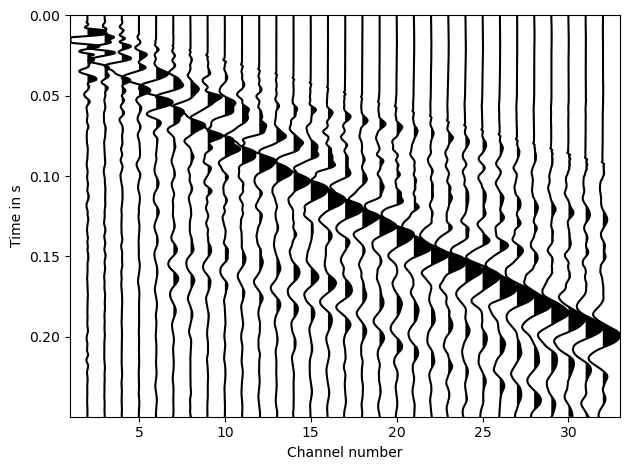

In [10]:
fig, ax = plt.subplots(1, 1)

for i in range(1, 32):
    dmax = np.max(np.abs(data[i, :]))
    amp = channel[i] + data[i, :]/dmax
    ax.plot(amp, t, 'k-')
    ax.fill_betweenx(t, amp, channel[i], where=amp > channel[i], lw=0, facecolor="black")

ax.set_xlabel("Channel number")
ax.set_ylabel("Time in s")
ax.set_xlim(1, 33)
ax.set_ylim(t[-1], t[0])
plt.tight_layout()
plt.show()

Note: We provide another Python package called __seisplot__ for displaying seismic data in a convenient way.